# Fluorescence punctua analysis work-flow
Written by Dominic Waithe 2017 (c)

### Functions necessary for analysis
Run this once at the beginning

In [2]:
#Libraries to import.
#Always run this once at the beginning
%pylab inline
import javabridge
import bioformats
import os
javabridge.start_vm(class_path=bioformats.JARS)


from patch_fn import return_valid_and_random_pts, register
from patch_fn import make_figure, drift_corr, collate_data,calculate_measurements
import find_maxima_fn as maxima

import scipy
from os import listdir
from os.path import isfile, join
from scipy import signal
from scipy.ndimage import interpolation
import copy
from scipy.ndimage import filters
from scipy import ndimage

import csv
import numpy as np
import tifffile
import json
from sklearn.preprocessing import scale
import cPickle as pickle


Populating the interactive namespace from numpy and matplotlib


### Pre-processes images to correct for drift and alignment. Saves out each image as tiff file
Each file is exported to a subfolder called RGB_im.

In [ ]:
#This is the code for correcting the two colour STED with confocal gfp signal (4 image channels).
#First it corrects the code by 

folderlist =[]
#This is where you add all the folders that your want to search through on your computer"""
#folderlist.append('/Users/dwaithe/Documents/collaborators/ReglinskiK/STED_imgs/20170821/HEK KO PEX14 pEB109 5Days/')
#folderlist.append('/Users/dwaithe/Documents/collaborators/ReglinskiK/STED_imgs/20170821/HEK KO PEX14 pJK28 5Days/')
#folderlist.append('/Users/dwaithe/Documents/collaborators/ReglinskiK/STED_imgs/20171010/HEK KO PEX14 pEB109 5 Days/')
#folderlist.append('/Users/dwaithe/Documents/collaborators/ReglinskiK/STED_imgs/20171010/HEK KO PEX14 pJK28 5 Days/')
#folderlist.append('/Users/dwaithe/Documents/collaborators/ReglinskiK/STED_imgs/20171024/HEK KO PEX14 pJK28 Day 5/')
#folderlist.append('/Users/dwaithe/Documents/collaborators/ReglinskiK/STED_imgs/20171024/HEK KO PEX14 pEB109 Day5/')
#folderlist.append('/Users/dwaithe/Documents/collaborators/ReglinskiK/STED_imgs/20171110/HEK KO PEX14 pEB109 Day5/')
#folderlist.append('/Users/dwaithe/Documents/collaborators/ReglinskiK/STED_imgs/20171110/HEK KO PEX14 pJK28 Day5/')

folderlist.append('/Users/dwaithe/Documents/collaborators/ReglinskiK/STED_imgs/20171122/HEK KO PEX14 pEB109 5 Days/')
folderlist.append('/Users/dwaithe/Documents/collaborators/ReglinskiK/STED_imgs/20171122/HEK KO PEX14 pJK28 5 Days/')

corr_x = 0#8,8 ;#The STED to confocal pixel correction in the x-dimension.
corr_y = 0#-4-8;#The STED to confocal pixel correction in the y-dimension.




data_store ={}
image_store ={}

for path in folderlist:
    
    
    filelist = [ f for f in listdir(path) if isfile(join(path,f)) ]
            
    for filename in filelist:
        
        if filename[:3] == '.DS':
            continue;
        
        if filename[-4:] != '.msr':
            continue
        if "CONF" in filename:
            continue
        #if filename != '01_HEK KO PEX14_pJK28_5Days_PEX14Ab600_PEX5KK114_STED.msr':
         #   continue
            
        #output for corrected and registered images
        output_path = path+'/RGB_im/'
        
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        
        print 'processing',filename
        im0raw = bioformats.load_image(path+filename, series=0) #confocal 
        im1raw = bioformats.load_image(path+filename, series=1) #sted APD2
        im2raw = bioformats.load_image(path+filename, series=2) #confocal
        im3raw = bioformats.load_image(path+filename, series=3) #sted APD3
            
        assert im0raw.shape == im1raw.shape == im2raw.shape == im3raw.shape, "Your images are not the same size"
        
        
        data_store[filename] = {}
        image_store[filename] = {}
        
        #This is just for comparison. This is the command which corrects confocal to STED detection channels.
        im0_after, im1_after, im2_after, im3_after = register(im0raw,im1raw,im2raw,im3raw,0,0)
        #Makes the raw figure with just the registration correction.
        imRGBB,imRGBA = make_figure(im0raw.astype(np.float64),im1raw.astype(np.float64),im2raw.astype(np.float64),im3raw.astype(np.float64))
        
        #Makes the drift corrected. Moves red relative to green. -ve is left and up.
        #The last two numbers define the confocal channel to STED offset. This is supplied by Silvia.
        im0_after, im1_after,im2_after, im3_after = drift_corr(im0_after,im1_after,im2_after,im3_after,corr_x,corr_y)
        #Makes figure with the registration between red and green channel
        imRGB2,imRGB1 = make_figure(im0_after,im1_after,im2_after,im3_after)
        
        
        output = np.zeros((4,im0_after.shape[0],im0_after.shape[1])).astype(np.float32)
        output[0,:,:] = im0_after
        output[1,:,:] = im1_after
        output[2,:,:] = im2_after
        output[3,:,:] = im3_after
        output = output*65535
        
        image_store[filename]['img_corr'] = output
        #plotting.
        figsize(12,12)
        figure()
        subplot(2,2,1)
        imshow(imRGBA)
        subplot(2,2,2)
        imshow(imRGB1)
        subplot(2,2,3)
        imshow(imRGBB)
        subplot(2,2,4)
        imshow(imRGB2)
        #savefig('pex/20150415 3 colori Perox/con_output_CorrFull2/fig'+filename, dpi=None, facecolor='w', edgecolor='w',
        #orientation='portrait', papertype=None, format=None,
        #transparent=False, bbox_inches=None, pad_inches=0.1,
        #frameon=None)
        metadata = dict(microscope='Abberior', shape=output.shape, dtype=output.dtype.str)
        metadata = json.dumps(metadata)
        tifffile.imsave(output_path+filename.split('.msr')[:-1][0]+'.tiff', output)
        
        
        
        
        

### Make measurements on your pre-processed data
Point this to look at the RGB_im subfolders which contain the .tiff files

In [24]:
import patch_fn as pf
reload(pf)
diameter_of_roi = 20; #Diameter of the ROI.
noi_tol = 10 #Noise tolerance for the maxima detection.
folderlist = []

#You should list all the folders containing output tiffs that you want to make measurements on.
folderlist.append('/Users/dwaithe/Documents/collaborators/ReglinskiK/STED_imgs/20170821/HEK KO PEX14 pEB109 5Days/RGB_im/')
folderlist.append('/Users/dwaithe/Documents/collaborators/ReglinskiK/STED_imgs/20170821/HEK KO PEX14 pJK28 5Days/RGB_im/')
folderlist.append('/Users/dwaithe/Documents/collaborators/ReglinskiK/STED_imgs/20171010/HEK KO PEX14 pEB109 5 Days/RGB_im/')
folderlist.append('/Users/dwaithe/Documents/collaborators/ReglinskiK/STED_imgs/20171010/HEK KO PEX14 pJK28 5 Days/RGB_im/')
folderlist.append('/Users/dwaithe/Documents/collaborators/ReglinskiK/STED_imgs/20171024/HEK KO PEX14 pJK28 Day 5/RGB_im/')
folderlist.append('/Users/dwaithe/Documents/collaborators/ReglinskiK/STED_imgs/20171024/HEK KO PEX14 pEB109 Day5/RGB_im/')
folderlist.append('/Users/dwaithe/Documents/collaborators/ReglinskiK/STED_imgs/20171122/HEK KO PEX14 pEB109 5 Days/RGB_im/')
folderlist.append('/Users/dwaithe/Documents/collaborators/ReglinskiK/STED_imgs/20171122/HEK KO PEX14 pJK28 5 Days/RGB_im/')

for path in folderlist:
    filelist = [ f for f in listdir(path) if isfile(join(path,f)) ]
    
    for filename in filelist:
        if filename !='.DS_Store' and filename[-5:] == '.tiff':
            image_store = {}
            data_store = {}
            data_store[filename[:-5]+'.msr'] = {}#pickle.load( open(  path+filename, "rb" ) )
            image_store[filename[:-5]+'.msr'] = {}
            image_store[filename[:-5]+'.msr']['img_corr'] = tifffile.imread(path+filename[:-5]+'.tiff')
            img = ndimage.filters.gaussian_filter(image_store[filename[:-5]+'.msr']['img_corr'][0,:,:], 2.0)
            ypts, xpts = maxima.find_maxima(noi_tol, img)
            height, width = img.shape

            o_xpts, o_ypts, rn_xpts, rn_ypts = return_valid_and_random_pts(xpts, ypts,diameter_of_roi,height, width)
            #plot(o_xpts, o_ypts,'o')

            data_store[filename[:-5]+'.msr']['height'] = height
            data_store[filename[:-5]+'.msr']['width'] = width        
            data_store[filename[:-5]+'.msr']['o_xpts'] = o_xpts
            data_store[filename[:-5]+'.msr']['o_ypts'] = o_ypts
            data_store[filename[:-5]+'.msr']['rn_xpts'] = rn_xpts
            data_store[filename[:-5]+'.msr']['rn_ypts'] = rn_ypts
            data_store = pf.calculate_measurements(image_store,data_store,diameter_of_roi,False) #for regions near perox.
            data_store = pf.calculate_measurements(image_store,data_store,diameter_of_roi,True) #for random regions.
            #output_data_path = output_path #'/Users/dwaithe/Documents/collaborators/ReglinskiK/STED_imgs/20170821/HEK KO PEX14 pEB109 5Days/RGB_im/'
    
            pickle.dump(data_store[filename[:-5]+'.msr'], open( path+filename[:-5]+'.p', "wb" ) )

processing 01_HEK KO PEX14_pEB109_5Days_PEX14Ab600_PEX5KK114_STED.msr
processing 01_HEK KO PEX14_pEB109_5Days_PEX14Ab600_PEX5KK114_STED.msr
processing 02_HEK KO PEX14_pEB109_5Days_PEX14Ab600_PEX5KK114_STED.msr
processing 02_HEK KO PEX14_pEB109_5Days_PEX14Ab600_PEX5KK114_STED.msr
processing 05_HEK KO PEX14_pEB109_5Days_PEX14Ab600_PEX5KK114_STED.msr
processing 05_HEK KO PEX14_pEB109_5Days_PEX14Ab600_PEX5KK114_STED.msr
processing 01_HEK KO PEX14_pJK28_5Days_PEX14Ab600_PEX5KK114_STED.msr
processing 01_HEK KO PEX14_pJK28_5Days_PEX14Ab600_PEX5KK114_STED.msr
processing 02_HEK KO PEX14_pJK28_5Days_PEX14Ab600_PEX5KK114_STED.msr
processing 02_HEK KO PEX14_pJK28_5Days_PEX14Ab600_PEX5KK114_STED.msr
processing 04_HEK KO PEX14_pJK28_5Days_PEX14Ab600_PEX5KK114_STED.msr
processing 04_HEK KO PEX14_pJK28_5Days_PEX14Ab600_PEX5KK114_STED.msr
processing 05_HEK KO PEX14_pJK28_5Days_PEX14Ab600_PEX5KK114_STED.msr
processing 05_HEK KO PEX14_pJK28_5Days_PEX14Ab600_PEX5KK114_STED.msr
processing 09_HEK KO PEX14_p

## Optional just for visualisation
Allows you print out visualise a specific file and the points on it.
Green are the peroxisomes points and red points are the random locations.

01_HEK KO PEX14_pJK28_5Days_PEX14Ab600_PEX5KK114_STED.tiff


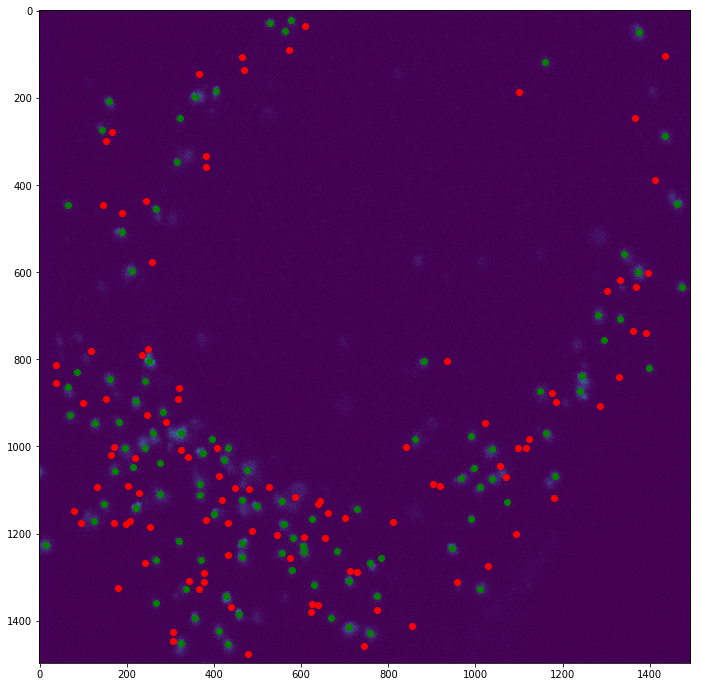

In [9]:

#insert you file reference here.
path_to_folder = '/Users/dwaithe/Documents/collaborators/ReglinskiK/STED_imgs/20171122/HEK KO PEX14 pJK28 5 Days/RGB_im/'
file_name = '01_HEK KO PEX14_pJK28_5Days_PEX14Ab600_PEX5KK114_STED.tiff'

##Shouldn't need to change anything here.
temp_store = pickle.load( open(  path_to_folder+file_name[:-4]+'p', "rb" ) )
temp_store['img_corr'] = tifffile.imread(path_to_folder+file_name[:-5]+'.tiff')
print file_name
figsize(12,12)
figure()
#Plot the peroxisome points (green)
plot(temp_store['o_xpts'],temp_store['o_ypts'],'go')
#Plot the random locations (red)
plot(temp_store['rn_xpts'],temp_store['rn_ypts'],'ro')
#Overlay points onto the image.
imshow(temp_store['img_corr'][0,:,:])


## Now we import specific data for the dataset comparisions

## A list of parameters that get measured.
#### Current measurements being made/calculated:
ch0_ave          - mean intensity from regions in channel 0.

ch1_ave          - mean intensity from regions in channel 1.

ch2_ave          - mean intensity from regions in channel 2.

ch3_ave          - mean intensity from regions in channel 3.

rand_ch0_ave     - mean intensity from random regions in channel 0.

rand_ch1_ave     - mean intensity from random regions in channel 1.

rand_ch2_ave     - mean intensity from random regions in channel 2.

rand_ch3_ave     - mean intensity from random regions in channel 3.

ch0_sum          - integrated intensity from regions in channel 0.

ch1_sum          - integrated intensity from regions in channel 1.

ch2_sum          - integrated intensity from regions in channel 2.

ch3_sum          - integrated intensity from regions in channel 3.

rand_ch0_sum     - integrated intensity from random regions in channel 0.

rand_ch1_sum     - integrated intensity from random regions in channel 1.

rand_ch2_sum     - integrated intensity from random regions in channel 2.

rand_ch3_sum     - integrated intensity from random regions in channel 3.

ch0_ave_norm     - mean intensity from regions in channel 0 normalised to max for each cell.

ch1_ave_norm     - mean intensity from regions in channel 1 normalised to max for each cell.

ch2_ave_norm     - mean intensity from regions in channel 2 normalised to max for each cell.

ch3_ave_norm     - mean intensity from regions in channel 3 normalised to max for each cell.

rand_ch0_ave_norm     - mean intensity from random regions in channel 0 normalised to max for each cell.

rand_ch1_ave_norm     - mean intensity from random regions in channel 1 normalised to max for each cell.

rand_ch2_ave_norm     - mean intensity from random regions in channel 2 normalised to max for each cell.

rand_ch3_ave_norm     - mean intensity from random regions in channel 3 normalised to max for each cell.

rand_ch13_pea         - Pearson's correlation from random regions in channel 1 compared to channel 3.

rand_ch13_pea_flip    - Pearson's correlation from random regions in channel 1 compared to channel 3 flipped left to right.

ch13_ch1_norm_to_ch3  - CH1 normalised to CH3.

ch31_ch3_norm_to_ch1  - CH3 normalised to CH1.


## Collect all measurements from saved files for individual datasets.

In [57]:
import patch_fn as pf
reload(pf)

dir_path = '/Users/dwaithe/Documents/collaborators/ReglinskiK/STED_imgs/'
folderlist = []
folderlist.append(dir_path+'20170821/HEK KO PEX14 pEB109 5Days/RGB_im/')
folderlist.append(dir_path+'20171010/HEK KO PEX14 pEB109 5 Days/RGB_im/')
folderlist.append(dir_path+'20171024/HEK KO PEX14 pEB109 Day5/RGB_im/')
folderlist.append(dir_path+'20171122/HEK KO PEX14 pEB109 5 Days/RGB_im/')

cond_A0 = pf.collect_data_measurements(folderlist[0:1])
cond_A1 = pf.collect_data_measurements(folderlist[1:2])
cond_A2 = pf.collect_data_measurements(folderlist[2:3])
cond_A3 = pf.collect_data_measurements(folderlist[3:4])
            
folderlist = []
folderlist.append(dir_path+'20170821/HEK KO PEX14 pJK28 5Days/RGB_im/')
folderlist.append(dir_path+'20171010/HEK KO PEX14 pJK28 5 Days/RGB_im/')
folderlist.append(dir_path+'20171024/HEK KO PEX14 pJK28 Day 5/RGB_im/')
folderlist.append(dir_path+'20171122/HEK KO PEX14 pJK28 5 Days/RGB_im/')

cond_B0 = pf.collect_data_measurements(folderlist[0:1])
cond_B1 = pf.collect_data_measurements(folderlist[1:2])
cond_B2 = pf.collect_data_measurements(folderlist[2:3])
cond_B3 = pf.collect_data_measurements(folderlist[3:4])

## Collect all measurements from saved files and combine into conditions

In [11]:
import patch_fn as pf
reload(pf)

dir_path = '/Users/dwaithe/Documents/collaborators/ReglinskiK/STED_imgs/'
folderlist = []
folderlist.append(dir_path+'20170821/HEK KO PEX14 pEB109 5Days/RGB_im/')
folderlist.append(dir_path+'20171010/HEK KO PEX14 pEB109 5 Days/RGB_im/')
folderlist.append(dir_path+'20171024/HEK KO PEX14 pEB109 Day5/RGB_im/')
folderlist.append(dir_path+'20171122/HEK KO PEX14 pEB109 5 Days/RGB_im/')

cond_A = pf.collect_data_measurements(folderlist)
            
folderlist = []
folderlist.append(dir_path+'20170821/HEK KO PEX14 pJK28 5Days/RGB_im/')
folderlist.append(dir_path+'20171010/HEK KO PEX14 pJK28 5 Days/RGB_im/')
folderlist.append(dir_path+'20171024/HEK KO PEX14 pJK28 Day 5/RGB_im/')
folderlist.append(dir_path+'20171122/HEK KO PEX14 pJK28 5 Days/RGB_im/')

cond_B = pf.collect_data_measurements(folderlist)

            

## Copy measurements for multiple datasets to clipboard.
Keeps data separate for each dataset for each condition and copies them as different columns.

In [62]:
measure_ = 'ch31_ch3_norm_to_ch1'#Change this to copy different conditions.
values_A0 = pf.collate_data(cond_A0,measure_)
values_A1 = pf.collate_data(cond_A1,measure_)
values_A2 = pf.collate_data(cond_A2,measure_)
values_A3 = pf.collate_data(cond_A3,measure_)

values_B0 = pf.collate_data(cond_B0,measure_)
values_B1 = pf.collate_data(cond_B1,measure_)
values_B2 = pf.collate_data(cond_B2,measure_)
values_B3 = pf.collate_data(cond_B3,measure_)

list_to_copy = [values_A0,values_B0,values_A1,values_B1,values_A2,values_B2,values_A3,values_B3]
pf.copy_to_the_clipboard(list_to_copy)

## Copy measurements for different conditions to clipboard.
Amalgamates all the data for a particular condition to the clipboard. Each condition is represented as a column.

In [61]:
measure_ = 'ch31_ch3_norm_to_ch1'#Change this to copy different conditions.
values_A = []
values_A.extend(pf.collate_data(cond_A0,measure_))
values_A.extend(pf.collate_data(cond_A1,measure_))
values_A.extend(pf.collate_data(cond_A2,measure_))
values_A.extend(pf.collate_data(cond_A3,measure_))
values_B = []
values_B.extend(pf.collate_data(cond_B0,measure_))
values_B.extend(pf.collate_data(cond_B1,measure_))
values_B.extend(pf.collate_data(cond_B2,measure_))
values_B.extend(pf.collate_data(cond_B3,measure_))

list_to_copy = [values_A,values_B]
pf.copy_to_the_clipboard(list_to_copy)

## And then format it for visualisation

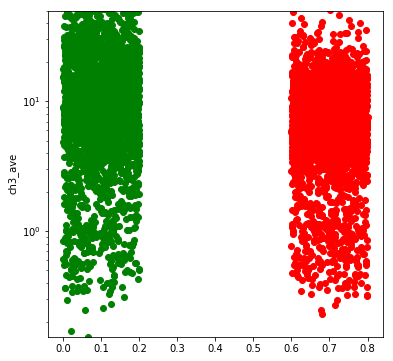

In [18]:
#Collates the measurements for each file and displays them
measure_ = 'ch3_ave'
values_A = pf.collate_data(cond_A,measure_)
semilogy(0.2*np.random.random(values_A.__len__()),values_A,'go')

ylim(0,50)
values_B = pf.collate_data(cond_B,measure_)
semilogy(0.2*np.random.random(values_B.__len__())+0.6,values_B,'ro')
ylabel(measure_)

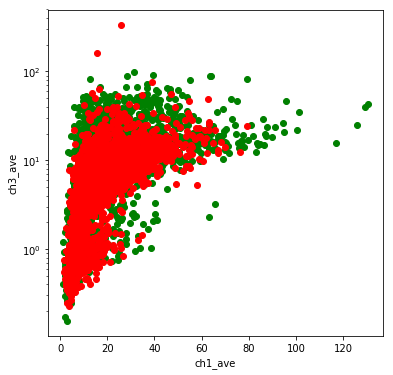

In [16]:
#Example of analysis.
#Comparing Ch1 and Ch3 in conditions A (green) and B (red).
figsize(6,6)
#Collates the measurements for each file and displays them
measurement_x = 'ch1_ave'
measurement_y = 'ch3_ave'
#Formats data into two lists for X and Y plot
values_x0,values_y0 = pf.collate_data_XY(cond_A,measurement_x,measurement_y)
#plots data and labels it with green points 'go'.
semilogy(values_x0,values_y0,'go')
#Formats data into two lists for X and Y plot   
values_x1,values_y1 = pf.collate_data_XY(cond_B,measurement_x,measurement_y)
#plots data and labels it with red points 'ro'.
semilogy(values_x1,values_y1,'ro')

#labels the access.
xlabel(measurement_x)
ylabel(measurement_y)
